In [3]:
#matlab numpy conversion http://mathesaurus.sourceforge.net/matlab-numpy.html

Questions:

* how can you preload more complex waveforms (e.g. sine cubed)?
* why does morphing conceptors sometimes zero the output?

In [4]:
%pylab inline
import scipy as sp

Populating the interactive namespace from numpy and matplotlib


In [5]:
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [6]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights
            
            
        

In [7]:
sr = 1000/15
freq = 20
waveLength = 1 / freq
waveLengthSamples = waveLength * sr
print("Wavelen: ", waveLength, " secs , " ,waveLengthSamples, ", samples, ", sr , "sr")


Wavelen:  0.05  secs ,  3.333333333333334 , samples,  66.66666666666667 sr


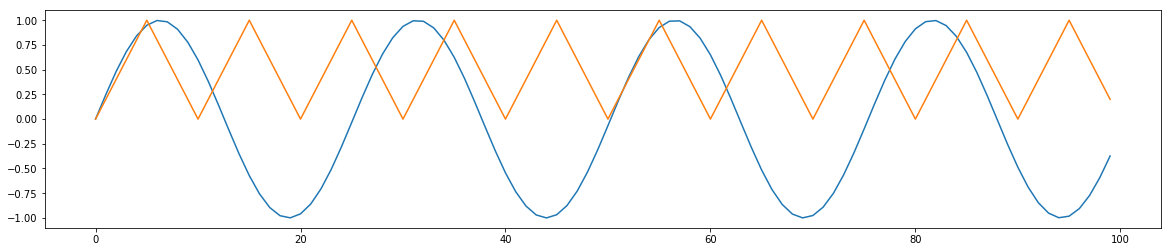

In [32]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

# pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
plot([pJ1b(x,4) for x in arange(100)])

# period2 = 2
# rawp = np.random.randn(period2)
# # rawp = np.array([1.1929,2.6856]);
# maxVal = np.max(rawp)
# minVal = np.min(rawp)
# print(rawp)
# rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
# pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
pTri = lambda n,p: (((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)
#pTri = lambda n,p: (n % (p/2))
plot([pTri(x,10) for x in arange(100)])


Initial training
NRMSE:  0.00104887484074
absWeight:  0.339911360528
Loading pattern  0
Loading pattern  1
W NMRSE:  0.0711130447434
absSize:  3.6392490111
Computing conceptors


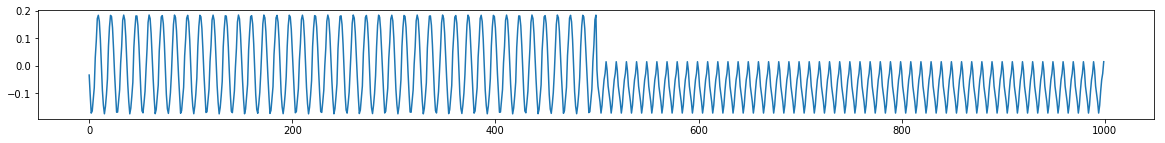

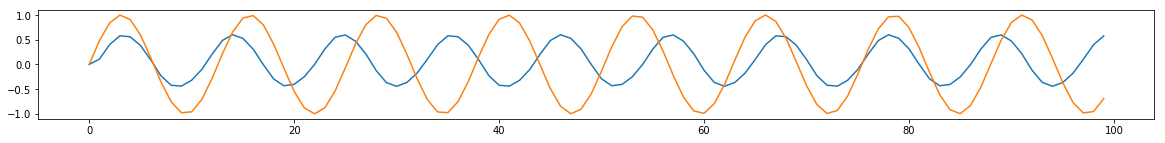

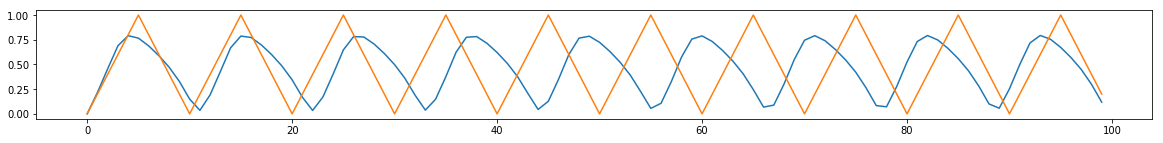

In [37]:

def makeNetwork(p):
    figsize(20,2)
    signalPlotLength = 15
   # pattern readout learning
    patterns = np.array([1,2])
    
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = np.random.randn(p['N'], 1)
    WbiasRaw = np.random.randn(p['N'], 1)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLengthWout']))
    pCollector = np.zeros((1, p['learnLengthWout']))
    x = np.zeros((p['N'],1))
    
    
    for n in arange(p['washoutLength'] + p['learnLength']):
        u = np.random.randn() * 1.5
        x = np.tanh((Wstar * x) + (Win * u + Wbias))
        if n >= p['washoutLength']:
            xCollector[:, n - p['washoutLength']] = x[:,0]
            pCollector[0, n - p['washoutLength']] = u
                       
#     print("Mean/Max/Min Activations, random network driven by noise")
#     plot(np.mean(xCollector.T, axis=1))
#     plot(np.max(xCollector.T, axis=1))
#     plot(np.min(xCollector.T, axis=1))
    
    Wout = linalg.inv(xCollector.dot(xCollector.conj().T) +  
                  (p['TychonovAlphaReadout'] * np.eye(p['N']))).dot(xCollector).dot(pCollector.conj().transpose()).conj().T
    print("Initial training")
    print("NRMSE: ", nrmse(Wout.dot(xCollector), pCollector))
    print("absWeight: ", mean(abs(Wout)))
    
    allTrainArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOldArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainTargs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOuts = np.zeros((1, p['patts'].size * p['learnLength']))
    xCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    SRCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    URCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_xPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_pPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    startXs =  np.zeros((p['N'], p['patts'].size), dtype=np.object)

    for i_pattern in range(p['patts'].size):
        print('Loading pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = zeros((p['N'], p['learnLength']))
        xOldCollector = zeros((p['N'], p['learnLength']))
        pCollector = zeros((1, p['learnLength']))
        x = zeros((p['N'],1))
        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            x = tanh((Wstar * x) + (Win * u) + Wbias)
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = x[:,0]
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                pCollector[0, n - p['washoutLength']] = u

        xCollectors[0,i_pattern] = xCollector
        R = xCollector.dot(xCollector.T) / p['learnLength']
        [Ux,sx,Vx] = svd(R)
        SRCollectors[0,i_pattern] = diag(sx)
        URCollectors[0,i_pattern] = Ux
        patternRs[0,i_pattern] = R

        startXs[:,i_pattern] = x[:,0]
        
        #needed?
        train_xPL[0,i_pattern] = xCollector[:,:signalPlotLength]
        train_pPL[0,i_pattern] = pCollector[0,:signalPlotLength]
        ###
        
        allTrainArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xCollector
        allTrainOldArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xOldCollector
        allTrainOuts[0, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = pCollector
        allTrainTargs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = Win.dot(pCollector)
         
    Wtargets = np.arctanh(allTrainArgs) - np.tile( Wbias, (1, p['patts'].size * p['learnLength']))

    W = linalg.inv(allTrainOldArgs.dot(allTrainOldArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldArgs).dot(Wtargets.conj().T).conj().T
    print("W NMRSE: ", mean(nrmse(W.dot(allTrainOldArgs), Wtargets)))
    print("absSize: ", mean(mean(abs(W), axis=0)))
    
    figure(1)
    plot(np.mean(W.dot(allTrainOldArgs).T, axis=1))

    print('Computing conceptors')
    
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = patternRs[0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(p['alphas'][i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)

    x_CTestPL = np.zeros((3, p['recallTestLength'], p['patts'].size))
    p_CTestPL = np.zeros((1, p['recallTestLength'], p['patts'].size))
    for i_pattern in range(p['patts'].size):
        C = Cs[0,i_pattern]
        x = 0.5 * np.random.randn(p['N'],1)
        for n in range(p['recallTestLength'] + p['washoutLength']):
            x = np.tanh(W.dot(x) + Wbias)
            x = C.dot(x)
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
                p_CTestPL[:,n-p['washoutLength'],i_pattern] = Wout.dot(x)
    for i_pattern in range(p['patts'].size):
        figure(2 + i_pattern)
        plot(p_CTestPL[:,:,i_pattern].T)
        plot([p['patts'][i_pattern](x) for x in arange(p['recallTestLength'])])
        
    return locals()

    
params = {'N':100, 'NetSR':1.6, 'NetinpScaling':1.6,'BiasScaling':0.3,'TychonovAlpha':0.0001,
         'washoutLength':100, 'learnLength':500, 'TychonovAlphaReadout':0.0001,
         'learnLengthWout':500, 'recallTestLength':100,
         'alphas':np.array([12.0,24.0]),
          'patts':np.array([lambda x:pJ1b(x,2), lambda x: pTri(x,10)])
         }

net = makeNetwork(params)


In [ ]:
#run a network
figsize(20,4)
runLength = 400
output = np.zeros(runLength)
x = 0.5 * np.random.randn(net['p']['N'],1)
for n in range(runLength):
    pos = (n / runLength * 10.0) - 1.0
#     pos = max(pos,0)
#     pos = min(pos,1)
    C = (net['Cs'][0,1].dot(pos)) + (net['Cs'][0,0].dot((1.0-pos))) 
#     C = (net['Cs'][0,0] * 0.5) + (net['Cs'][0,1] * 0.5)
#     C = net['Cs'][0,1]
    Wsr = net['W'].dot(1.2)
    for i_oversample in range(1):
        x = np.tanh(Wsr.dot(x) + net['Wbias'])
        x = C.dot(x)
    #x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
    output[n] = net['Wout'].dot(x)
    
plot(output)

In [ ]:
net['p']['N']

In [ ]:
a+1

In [ ]:
### settings ###
hostport = 57120 ## where the OSC goes
###
hostip = "127.0.0.1"
myip = "127.0.0.1"
myport = 57805
###

import time
import OSC


# ========= send osc ============

def sendOSCMessage( path, args ):
  msg = OSC.OSCMessage()
  msg.setAddress( path )
  #print args
  for a in args:
    msg.append( a )
  try:
    oschost.send( msg )
    if verbose:
      print( "sending message", msg )
  except OSC.OSCClientError:
    if verbose:
      print( "error sending message", msg )

    #sendOSCMessage( "/sensenode/imu", mpusendData )

#------------ OSC handlers --------------

def handler_led( path, types, args, source ):        
    print( "Sensor input:", args, len(args) )
    #call function; args is an array with the values that are sent
      
####################### main ################

oschost = OSC.OSCClient()
send_address = ( hostip, hostport )
oschost.connect( send_address )

receive_address = ( myip, myport )
osc = OSC.OSCServer( receive_address )

# add handlers
osc.addMsgHandler( "/sensenode/address", handler_led )  
# stopOSC = False
# def runOSCServer():
#     while True and not stopOSC:
#         osc.handle_request()
#         time.sleep(0.0001)


In [ ]:
import threading
thread = threading.Thread( target = osc.serve_forever )

thread.start()

In [ ]:
runOSCServer()

In [ ]:
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()
jobs.new('runOSCServer()')

In [ ]:
1*9

In [ ]:
jobs.status()

In [ ]:
stopOSC=True

In [ ]:
np.tile( Wbias, (1, patterns.size * learnLength))

In [ ]:
a = zeros((3,5), dtype=np.object)
a[:,3]

In [ ]:
mean(mean(abs(W), axis=0))

In [ ]:
q = np.random.random((3,5))
q

In [ ]:
a[:,0]

In [ ]:
q[:, 0] = a[:,0]

In [ ]:
q

In [ ]:
[U,s,V] = np.linalg.svd(np.ones((3,3)))
print U
print diag(s)
print V.T

In [ ]:
patterns

In [ ]:
#!/usr/bin/env python

from liblo import *
import sys

try:
    server.free()
except:
    pass

class MyServer(ServerThread):
    def __init__(self):
        ServerThread.__init__(self, 2323)

    @make_method('/cx', 'f')
    def cx_callback(self, path, args):
        f = args[0]
        print("received message ",path," with arguments: ", f)
#        send(("127.0.0.1",57120), "/rbn", f*0.8)

    @make_method('/async', 'f')
    def async_callback(self, path, args):
        i = int(args[0])
#        print "received message '%s' with arguments: %i" % (path, i)

    @make_method('/asyncrange', 'f')
    def asyncrange_callback(self, path, args):
        f = args[0]
#        print "received message '%s' with arguments: %i" % (path, i)


    
    @make_method(None, None)
    def fallback(self, path, args):
        print("received unknown message ", s)

try:
    server = MyServer()
except err:
    print(str(err))

server.start()




In [ ]:
#test
try:
    target = Address(2323)
except AddressError as err:
    print (str(err))
    sys.exit()

# send message "/foo/message1" with int, float and string arguments
send(target, "/cx", 0.123)

In [ ]:
figsize(20,10)
# plot([tan(x/0.3) * sin(x/50.0)  * 0.1 for x in arange(1000)], color='purple')
# plot([tan(x/0.15) * 0.1 for x in arange(1000)], color='purple')
for i in range(100):
    plot([sin(x/50.0 + (i/19.0)) * 100.0 for x in arange(1000)], color='blue', alpha=0.3)
    plot([sin(x/50.0) * 50.0 + 100 for x in arange(1000)], color='pink', alpha=0.9)
    plot([sin(x/50.0) * 50.0 for x in arange(1000)], color='purple', alpha=0.5)


In [19]:
%run conceptors.py

In [20]:
def onMorph():
    print("onMorph")
    
makeOSCServer(onMorph)

server running
